Using a CONSTANT oracle that always returns 0


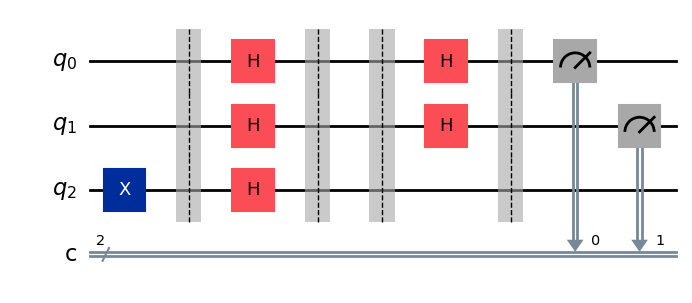

Measurement outcomes: {'00': 1024}
Conclusion: f(x) is CONSTANT.


Using a BALANCED oracle.


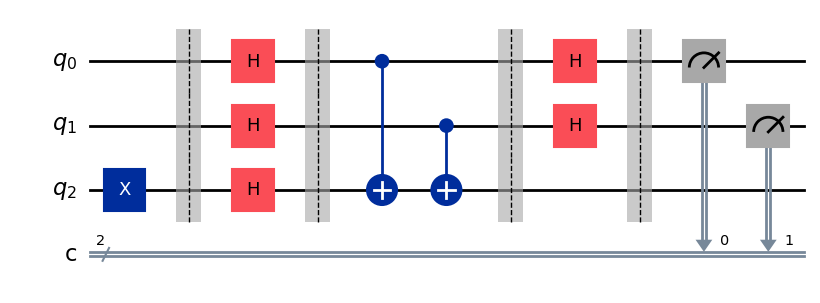

Measurement outcomes: {'11': 1024}
Conclusion: f(x) is BALANCED.


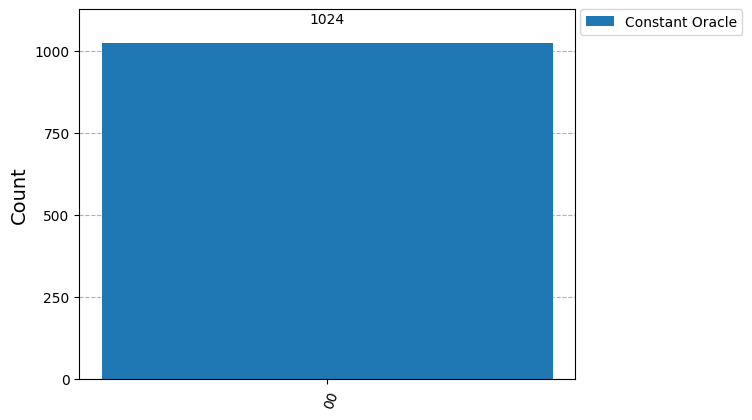

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from IPython.display import display

def create_constant_oracle(n_qubits, output):
    """
    Creates a 'constant' oracle.
    If `output` is 0, the oracle always returns 0.
    If `output` is 1, the oracle always returns 1.
    """
    oracle = QuantumCircuit(n_qubits + 1)
    # If the oracle should always output 1, flip the output qubit.
    if output == 1:
        oracle.x(n_qubits)
    return oracle

def create_balanced_oracle(n_qubits):
    """
    Creates a 'balanced' oracle.
    For demonstration, this balanced oracle flips the output qubit when the first
    input qubit is 1 (i.e. a single CX gate from qubit 0 to the output qubit).
    """
    oracle = QuantumCircuit(n_qubits + 1)
    # Apply a CX from the first input qubit to the ancilla.
    oracle.cx(0, n_qubits)
    oracle.cx(1, n_qubits)
    return oracle

def deutsch_jozsa_circuit(oracle, n_qubits):
    """
    Assembles the full Deutsch-Jozsa circuit.
    1. Initialize input qubits to |0> and output qubit to |1>.
    2. Apply Hadamard gates to all qubits.
    3. Append the oracle.
    4. Apply Hadamard gates to the input qubits.
    5. Measure the input qubits.
    """
    # Create a circuit with n input qubits and 1 output qubit; measure only inputs.
    dj_circuit = QuantumCircuit(n_qubits + 1, n_qubits)
    
    # (1) Set the output qubit to |1>
    dj_circuit.x(n_qubits)
    dj_circuit.barrier()
    # (2) Apply Hadamard to all qubits.
    for qubit in range(n_qubits + 1):
        dj_circuit.h(qubit)
    dj_circuit.barrier()
    # (3) Append the oracle.
    dj_circuit.compose(oracle, inplace=True)
    dj_circuit.barrier()
    # (4) Apply Hadamard again to the input qubits only.
    for qubit in range(n_qubits):
        dj_circuit.h(qubit)
    dj_circuit.barrier()
    # (5) Measure the input qubits.
    for qubit in range(n_qubits):
        dj_circuit.measure(qubit, qubit)
    
    return dj_circuit

def run_deutsch_jozsa_test(n_qubits, oracle_type='constant', constant_output=0, shots=1024):
    """
    Builds and runs the Deutsch-Jozsa circuit for either a constant or balanced oracle.
    Returns the measurement counts dictionary.
    """
    if oracle_type == 'constant':
        oracle = create_constant_oracle(n_qubits, constant_output)
        print(f"Using a CONSTANT oracle that always returns {constant_output}")
    else:
        oracle = create_balanced_oracle(n_qubits)
        print("Using a BALANCED oracle.")
    
    # Create the Deutsch-Jozsa circuit.
    dj_circ = deutsch_jozsa_circuit(oracle, n_qubits)
    
    # For visual reference, display the circuit.
    display(dj_circ.draw('mpl'))
    
    # Run the circuit using the Aer simulator.
    simulator = Aer.get_backend('aer_simulator')
    transpiled_circ = transpile(dj_circ, simulator)
    job = simulator.run(transpiled_circ, shots=shots)
    result = job.result()
    counts = result.get_counts(transpiled_circ)
    
    print("Measurement outcomes:", counts)
    
    # Interpret the measurement.
    measured_result = max(counts, key=counts.get)
    if measured_result == '0' * n_qubits:
        print("Conclusion: f(x) is CONSTANT.")
    else:
        print("Conclusion: f(x) is BALANCED.")
    
    return counts

# Run both tests
n_qubits = 2
const_counts = run_deutsch_jozsa_test(n_qubits=n_qubits, oracle_type='constant', constant_output=0, shots=1024)
print("\n" + "="*50 + "\n")
bal_counts = run_deutsch_jozsa_test(n_qubits=n_qubits, oracle_type='balanced', shots=1024)

# Plot both histograms on the same plot.
# plot_histogram([const_counts, bal_counts], legend=['Constant Oracle', 'Balanced Oracle'])
plot_histogram([const_counts], legend=['Constant Oracle'])
# plot_histogram([bal_counts], legend=[ 'Balanced Oracle'])

